# 1D Fourier example

$\phi(x) = (\exp(2\pi i k x))_{|k|\leq f_c}$.


In [133]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import time

import mmd as mmd
import operators as myops
import lasso as ls
import continuous_BP as cbp
from numpy import linspace
from helper import prune

from importlib import reload  # Python 3.4+
reload(ls)
reload(myops)
reload(mmd)

<module 'mmd' from '/Users/u2272691/Documents/GitHub/continuous-BP/Python/cBP_paper/mmd.py'>

In [134]:
#helper funs

error_fun = lambda x,a,y,b : mmd.mmd_laplace(x[:,None],a, y[:,None],b)


Get the discretized Fourier operator A and discretized gradient dA.

In [135]:
nx= 20
xgrid = linspace(0,1,nx)

#define Fourier
fq = 4
Phi,  dPhi = myops.getFourierOp(fq)
A, dA = Phi(xgrid), dPhi(xgrid)
scaleA = 1/np.sqrt(np.sum(np.abs(dA)**2,axis=0))



Define the Lasso and SR Lasso solvers with support pruning

In [136]:
def Grid_Lasso(y_obs,la,tol=1e-8):
    # Call Lasso
    al_val = ls.groupLasso(A, y_obs,la,1)
    
    #prune out small spikes
    al_val, grid_lasso = prune(al_val, xgrid,tol)
    return al_val, grid_lasso

def SRLasso(y_obs,la,tau,tol=1e-8):
    a,shift = cbp.SRLasso(A, dA, y_obs,la,tau)
    a, grid = prune(a, xgrid +shift,tol)  
    return a,grid



Define ground truth and observations

In [177]:
#define ground truth
h1 = xgrid[1]-xgrid[0] #grid-size
spacing = 0.3 #float between 0 and 1. how much to move inside grid.

results_dir =  'results/{fc}_{nx}_{spacing}'.format(fc=fq, nx=nx, spacing=int(spacing*100))
!mkdir $results_dir

#true positions
shift = np.array([h1,-h1])*spacing
x_true = np.array( [ xgrid[int(nx*.25)], xgrid[int(nx*.65)]])+shift

#true amplitudes
a_true = np.array([1-2j, -2+1j])

#observations
y_true = Phi(x_true)@a_true



mkdir: results/4_20_30: File exists


0.20978530551797173
error: 0.08460003443560382
error: 0.24371502327723513


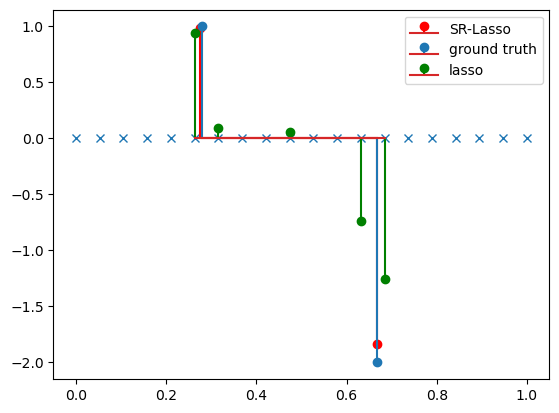

In [178]:
#test reconstruction

noise_lev = 0.1*np.linalg.norm(y_true)/np.sqrt(len(y_true))
y_obs = y_true +noise_lev*np.random.randn( *y_true.shape) 
print(np.linalg.norm(y_true-y_obs))

la= 1e-1
tau= 1
a,grid = SRLasso(y_obs,la,tau,tol=1e-5)
a_lasso, grid_lasso = Grid_Lasso(y_obs,la,tol=1e-5)

    
#display
plt.plot(xgrid,0*xgrid,'x') #grid points
plt.stem(grid,np.real(a),'r', label='SR-Lasso')
plt.stem(x_true, np.real(a_true), label='ground truth')
plt.stem(np.real(grid_lasso)%1, np.real(a_lasso), 'g', label='lasso')
plt.legend()

print('error:', error_fun(grid,a,x_true, a_true ))
print('error:', error_fun(grid_lasso,a_lasso,x_true, a_true ))



### Run Lasso and find the optimal $\lambda$ parameter


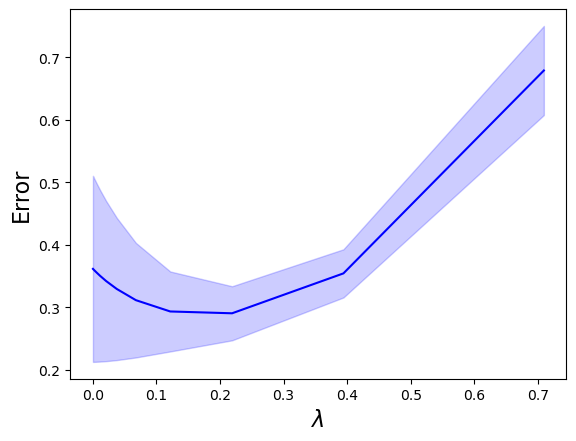

optimal lambda: 0.21895308552693094 error 0.22529646190977268


In [179]:

#lambda range to test on
L=20
la_max = np.max(np.abs(A.conjugate().T@y_true))
la_vals = np.logspace(-5,np.log10(la_max/3),L)

Runs = 20
Res_Lasso = np.zeros((L,Runs))

for r in range(Runs):
    np.random.seed(1+r)
    y_obs = y_true + noise_lev*np.random.randn( *y_true.shape) 
    for i in range(L):
        la = la_vals[i]
        al_val,grid_lasso = Grid_Lasso(y_obs,la,1e-4)
        err = error_fun(x_true, a_true, grid_lasso, al_val)
        Res_Lasso[i,r] = err

        
import matplotlib.pyplot as plt


#save and display
mean_curve = np.mean(Res_Lasso, axis=1)
std_curve = np.std(Res_Lasso, axis=1)
lower_bound = mean_curve - 1 * std_curve
upper_bound = mean_curve + 1 * std_curve
plt.plot(la_vals, mean_curve, color='b')
plt.fill_between(la_vals, lower_bound, upper_bound, color='b', alpha=0.2)

plt.ylabel('Error', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)
plt.savefig(results_dir+'/lambda_Lasso.png', bbox_inches='tight',dpi=200, transparent=True)
plt.show()

#retrive lambda giving the smallest error
idx = np.where(mean_curve==np.min(mean_curve))[0][0]
la =la_vals[idx]
print('optimal lambda:' , la, 'error',np.min(Res_Lasso_ave))



### For optimal $\lambda$, run SR-Lasso for different  $\tau$ parameters

In [184]:
#experiment 1: changing noise and tau. Fixed lambda
K1 = 10
tau_vals1 = np.linspace(0,1,K1)
la=0.1
Runs = 20
Res_SRLasso = np.zeros((K1,Runs))
for r in range(Runs):
    
    np.random.seed(1+r)
    y_obs = y_true + noise_lev*np.random.randn(*y_true.shape)

    for i in range(K1):
        a,grid = SRLasso(y_obs,la,tau_vals1[i],tol=1e-4)
        err = error_fun(x_true, a_true, grid,a) 
        Res_SRLasso[i,r]=err
        
        

optimal params: 0.8888888888888888 error 0.12637791774450577


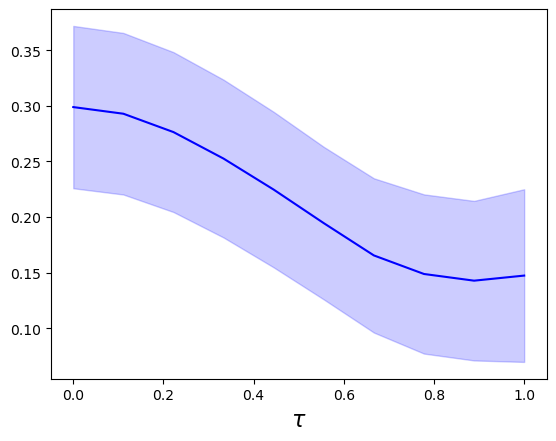

In [185]:
import matplotlib.pyplot as plt
import time


#save and display
mean_curve = np.mean(Res_SRLasso, axis=1)
std_curve = np.std(Res_SRLasso, axis=1)
lower_bound = mean_curve - 1 * std_curve
upper_bound = mean_curve + 1 * std_curve
plt.plot(tau_vals1, mean_curve, color='b')
plt.fill_between(tau_vals1, lower_bound, upper_bound, color='b', alpha=0.2)

plt.xlabel(r'$ \tau $', fontsize=16)
#plt.ylabel('Error', fontsize=16)
plt.savefig(results_dir+'/tau_SRLasso.png', bbox_inches='tight',dpi=200, transparent=True)


#retrieve optimal tau
idx = np.where(mean_curve==np.min(mean_curve))[0][0]
tau1 = tau_vals1[idx]
print('optimal params:', tau1, 'error',np.min(Res_SRLasso_ave))



In [175]:
np.random.seed(4)
#rerun both with same noise instance

y_obs = y_true + noise_lev*np.random.randn( *y_true.shape)
a,grid = SRLasso(y_obs,la,tau1,1e-4)

print('SR Lasso flatnorm',error_fun(x_true,a_true, grid,a))

al_val,grid_lasso= Grid_Lasso(y_obs,la,1e-4)

print('Lasso flatnorm',error_fun(x_true, a_true, grid_lasso,al_val))



SR Lasso flatnorm 0.16610887122303256
Lasso flatnorm 0.2835021913722465


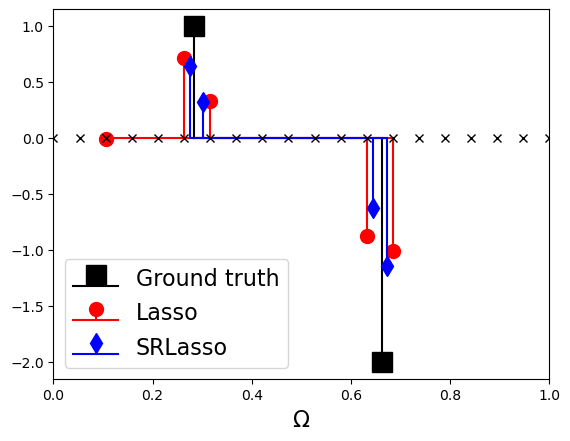

In [176]:
S = lambda x: np.real(x)

markerline, stemlines, baseline = plt.stem(x_true, S(a_true),linefmt='k-',
                                           markerfmt='ks',basefmt='k-',label='Ground truth')
plt.setp(markerline,  markersize = 15)

markerline, stemlines, baseline = plt.stem(grid_lasso,S(al_val),linefmt='r-',
                                           markerfmt='ro',basefmt='r-',label='Lasso')
plt.setp(markerline,  markersize = 10)
markerline, stemlines, baseline =  plt.stem(grid,S(a),linefmt='b-', 
                                            markerfmt='bd',basefmt='b-',label='SRLasso')
plt.plot(xgrid, 0*xgrid,'kx')

plt.setp(markerline,  markersize = 10)
plt.xlim([0,1])

plt.legend( fontsize="16",loc='lower left')
plt.xlabel('$\Omega$',fontsize="16")

plt.savefig(results_dir+'/comparison.png', bbox_inches='tight',dpi=200, transparent=True)

plt.show()


In [115]:
text = '${nx}$&${spacing:.2f}$&${tau1:.2f}$&${lambd:.3f}$&${Res_Lasso_ave:.3f}$&${Res_SRLasso_ave:.3f}$\\\\'.format(
    nx=nx,spacing=spacing,tau1=tau1,lambd=la,Res_Lasso_ave =np.min(Res_Lasso_ave), Res_SRLasso_ave = np.min(Res_SRLasso_ave) )


    
outputfile = 'results/'+str(fq)+'output.txt'
    
print(text,file=open(outputfile, 'a'))
print(text)

$20$&$0.20$&$0.67$&$0.224$&$0.225$&$0.132$\\


### Record the Lasso error vs SR-Lasso error and support size  as a function of $\lambda$.

In [129]:

#lambda range to test on
L=20
la_max = np.max(np.abs(A.conjugate().T@y_true))
la_vals = np.logspace(-5,np.log10(la_max/3),L)

Runs = 20
Res_Lasso = np.zeros((L,Runs))
Res_SRLasso = np.zeros((L,Runs))
Supp_Lasso = np.zeros((L,Runs))
Supp_SRLasso = np.zeros((L,Runs))

for r in range(Runs):
    np.random.seed(1+r)
    y_obs = y_true + noise_lev*np.random.randn( *y_true.shape) 
    for i in range(L):
        la = la_vals[i]
        al_val,grid_lasso = Grid_Lasso(y_obs,la,1e-2)
        Res_Lasso[i,r] = error_fun(x_true, a_true, grid_lasso, al_val)
        Supp_Lasso[i,r] = len(al_val)
        
        a,grid = SRLasso(y_obs,la,1,1e-2)
        Res_SRLasso[i,r] = error_fun(x_true, a_true, grid, a)
        Supp_SRLasso[i,r] = len(a)

      

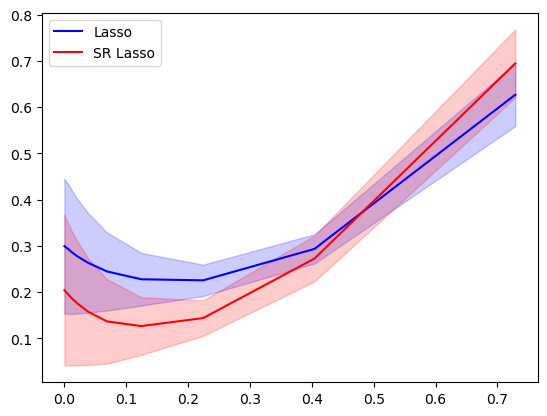

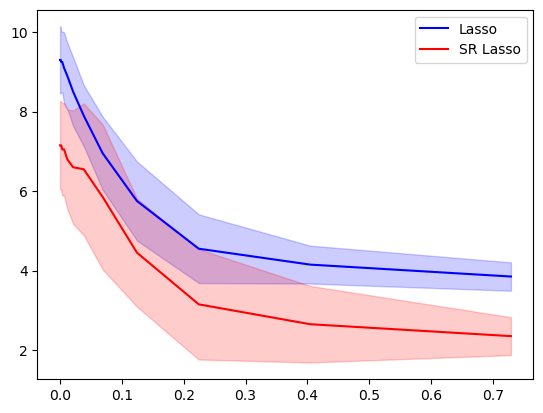

In [132]:


plots = [Res_Lasso, Res_SRLasso]
colors = ['b','r']
labels=['Lasso', 'SR Lasso']
for i in range(2):
    E = plots[i]
    mean_curve = np.mean(E, axis=1)
    std_curve = np.std(E, axis=1)
    lower_bound = mean_curve - 1 * std_curve
    upper_bound = mean_curve + 1 * std_curve
    plt.plot(la_vals, mean_curve, color=colors[i],label=labels[i])
    plt.fill_between(la_vals, lower_bound, upper_bound, color=colors[i], alpha=0.2)

plt.legend()
plt.show()

plots = [Supp_Lasso, Supp_SRLasso]

colors = ['b','r']
labels=['Lasso', 'SR Lasso']
for i in range(2):
    E = plots[i]
    mean_curve = np.mean(E, axis=1)
    std_curve = np.std(E, axis=1)
    lower_bound = mean_curve - 1 * std_curve
    upper_bound = mean_curve + 1 * std_curve
    plt.plot(la_vals, mean_curve, color=colors[i],label=labels[i])
    plt.fill_between(la_vals, lower_bound, upper_bound, color=colors[i], alpha=0.2)

plt.legend()
plt.show()

